In [1]:
import numpy as np
import json
import yaml
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from matplotlib.ticker import MaxNLocator

import xobjects as xo
import xtrack as xt
import xpart as xp

import pymadx

No pytransport functionality
No pytransport functionality


In [2]:
# SPECIFIC CONVERSION FUNCTIONS FOR THIS EXAMPLE

def change_coordinates_to_b1(df):
    df['s_b1'] = np.where(df['s'] <=  end_s-TTCS_loc, end_s-TTCS_loc-df['s'],2*end_s-TTCS_loc-df['s'])
    df = df.sort_values(by="s_b1")
    return df


def change_coordinates_to_b1_f(s):
    if s <=  end_s-TTCS_loc:
        s_b1 = end_s-TTCS_loc-s,
        return float(s_b1[0])
    else: 
        s_b1 = 2*end_s-TTCS_loc-s
        return float(s_b1)
    
def extract_channelled(df):
    df=df.loc[(df['s_b1']<end_s-TTCS_loc) & (df['s_b1']>end_s-TCLA_loc)]
    return df

In [3]:
# STANDARD CONVERSION FUNCTIONS

def _norm_to_geom_emittance(norm_emittance, E0, E):
    betagamma = _calc_betagamma(E0, E)
    return norm_emittance / betagamma

def _calc_betagamma(E0, E):
    gamma = float(E)/E0
    beta = np.sqrt(1.-(1./gamma)**2)
    return beta*gamma

def rad_to_deg(n):
    return n*180/np.pi



In [4]:
# LOAD APERTURES FUNCTIONS

def find_apertures(line):
    i_apertures = []
    apertures = []
    for ii, ee in enumerate(line.elements):
        if ee.__class__.__name__.startswith('Limit'):
            i_apertures.append(ii)
            apertures.append(ee)
    return np.array(i_apertures), np.array(apertures)


def load_apertures(line):
    apertures = find_apertures(line)

    ap_spos = np.take(line.get_s_elements(), apertures[0])

    ap_limit_dict = {}
    for ii, ap in enumerate(apertures[1]):
        ap_dict = ap.to_dict()
        cname = ap.__class__.__name__
        if cname == 'LimitEllipse':
            x_min = -ap_dict['a']
            x_max = ap_dict['a']
            y_min = -ap_dict['b']
            y_max = ap_dict['b']
        elif cname == 'LimitRect':
            x_min = ap_dict['min_x']
            x_max = ap_dict['max_x']
            y_min = ap_dict['min_y']
            y_max = ap_dict['max_y']
        elif cname == 'LimitRectEllipse':
            x_min = -ap_dict['max_x']
            x_max = ap_dict['max_x']
            y_min = -ap_dict['max_y']
            y_max = ap_dict['max_y']
        elif cname == 'LimitRacetrack':
            # TODO: is this correct?
            x_min = ap_dict['min_x']
            x_max = ap_dict['max_x']
            y_min = ap_dict['min_y']
            y_max = ap_dict['max_y']
        elif cname == 'LimitPolygon':
            x_intercepts, y_intercepts = find_axis_intercepts(ap_dict['x_vertices'], 
                                                             ap_dict['y_vertices'])
            x_min = min(x_intercepts)
            x_max = max(x_intercepts)
            y_min = min(y_intercepts)
            y_max = max(y_intercepts)
        else:
            raise ValueError(f'Cannot proceed with aperture: {ap_dict}')
        s_pos = ap_spos[ii]
        ap_limit_dict[s_pos] = {'xmin': x_min, 'xmax': x_max, 'ymin': y_min, 'ymax': y_max, 'apertype': cname}
    
    ap_limit_df = pd.DataFrame.from_dict(ap_limit_dict, orient='index')

    return ap_limit_df

In [5]:
# LOAD COLLIMATORS FUNCTIONS

def add_collimator_halfgap(coll_df, nemitt_x, nemitt_y, 
                           reference_mass, reference_energy):
        
    # Calculate the geometric emittances first
    emit_geom_x = _norm_to_geom_emittance(nemitt_x, reference_mass, reference_energy)
    emit_geom_y = _norm_to_geom_emittance(nemitt_y, reference_mass, reference_energy)

    openings = []
    sigmas_x = []
    sigmas_y = []
    for name, parameters in coll_df.iterrows():
        betx = parameters["betx"]
        bety = parameters["bety"]

        nsigma = parameters["gap"]
        angle  = parameters["angle"]

        sigma_x = np.sqrt(betx * emit_geom_x)
        sigma_y = np.sqrt(bety * emit_geom_y)

        a = nsigma * sigma_x
        b = nsigma * sigma_y

        x = a * np.cos(angle)
        y = b * np.sin(angle)

        sigmas_x.append(sigma_x)
        sigmas_y.append(sigma_y)
        openings.append(np.sqrt(x**2 + y**2))

    coll_df['sigma_x'] = sigmas_x
    coll_df['sigma_y'] = sigmas_y
    coll_df['opening'] = openings
    


def load_coll_yaml(filename, optics_df, reference_mass, reference_energy,
                          nemitt_x = 3.5e-6, nemitt_y = 3.5e-6, beam='b2' ):
    with open(filename, 'r') as file:
           collimators = yaml.safe_load(file)
    
    b2_coll = collimators['collimators'][beam]
    df = pd.DataFrame.from_dict(b2_coll, orient="index")
    df =df.rename_axis('name').reset_index()
    coll_list=df['name'].to_list()
    
    df_col_twiss = optics_df[optics_df['name'].isin(coll_list)]
    df_coll_tot = pd.merge(df, df_col_twiss, on="name")
    
    add_collimator_halfgap(df_coll_tot, nemitt_x, nemitt_y, 
                           reference_mass, reference_energy)
    return df_coll_tot

In [6]:
# PLOT APERTURES 

def plot_apertures(ap_limit_df, plot_axis, plane, plot_apertype=False):

    plot_bounds = []
    if 'h' in plane:
        plot_bounds.append(['xmin', 'xmax'])
    if 'v' in plane:
        plot_bounds.append(['ymin', 'ymax'])
        
    for bounds in plot_bounds:
        # dummy plot for label and colour
        label_string = 'Hor. aper' if bounds[0].startswith('x') else 'Ver. aper'
        p = plot_axis.plot([], [], label=label_string) 
        s = ap_limit_df.index.values
        ap_limit_df['s'] = s
        ap_limit_df = change_coordinates_to_b1(ap_limit_df)
        for bound in bounds:
            lim_data = ap_limit_df[bound].values #convert_m_to_mm(ap_limit_df[bound].values)
            p = plot_axis.plot(ap_limit_df['s_b1'], lim_data, c="C7")
            if bound.endswith('min'):
                p = plot_axis.fill_between(ap_limit_df["s_b1"], lim_data, min(plot_axis.get_yticks()), color='C7', alpha=0.3)
            if bound.endswith('max'):
                p = plot_axis.fill_between(ap_limit_df["s_b1"], max(plot_axis.get_yticks()), lim_data, color='C7', alpha=0.3)

        if plot_apertype:
            for apertype in set(ap_limit_df.apertype):
                apers = ap_limit_df[ap_limit_df.apertype == apertype]
                pat = plot_axis.scatter(apers.index.values, 
                                        #convert_m_to_mm(apers[bounds[0]].values),
                                        apers[bounds[0]].values,
                                        marker='.',
                                        label=apertype)
                plot_axis.scatter(apers.index.values, 
                                  #convert_m_to_mm(apers[bounds[1]].values),
                                  apers[bounds[1]].values,
                                  marker='.',
                                  color=pat.get_facecolors()[0])


In [7]:
# PLOT COLLIMATORS 

def plot_collimators(coll_data, ax, plane):

    coll_data = change_coordinates_to_b1(coll_data)


    hors = (coll_data['angle'] <  rad_to_deg(0.1)) | (coll_data['angle'] >  rad_to_deg(6.1))
    vers = (coll_data['angle'] >  rad_to_deg(1.5)) & (coll_data['angle'] <  rad_to_deg(1.6))


    collimators_hor = coll_data.loc[hors]
    collimators_ver = coll_data.loc[vers]
    collimators_ske = coll_data.loc[(~hors) & (~vers)]
    


    if plane == 'h':
        in_plane_collimators = collimators_hor
        off_plane_collimators = pd.concat([collimators_ver, collimators_ske])
    elif plane == 'v':
        in_plane_collimators = collimators_ver
        off_plane_collimators = pd.concat([collimators_hor, collimators_ske])
    else:
        raise Exception(f'Cannot use plane "{[plane]}", '
                        'allowed planes for aperture plot are h and v')

    coll_lw = 1

    for index, coll in in_plane_collimators.iterrows():
        s_centre = coll["s_b1"]
        orbit = coll['x'] if plane=='h' else coll['y']

        sstart  = s_centre - coll["length"]/2
        send    = s_centre + coll["length"]/2
        hgap    = coll["opening"]
        w       = send-sstart
        top_lim = plt.ylim()[1]*2
        bot_lim = plt.ylim()[0]*2
        h       = top_lim - hgap
        
        if coll['crystal']== 'strip' or coll['crystal']== 'quasi-mosaic':
            if coll['side'] == 'left':
                jaw = matplotlib.patches.Rectangle((sstart, hgap), w, h, angle=0.0, 
                                          fc="r", ec="r", lw=coll_lw, zorder=10)
                ax.add_patch(jaw)
            elif coll['side'] == 'right':        
                jaw = matplotlib.patches.Rectangle((sstart, bot_lim), w, h, angle=0.0, 
                                          fc="r", ec="r", lw=coll_lw,  zorder=10)
                ax.add_patch(jaw)
            
        else:
            upper_jaw = matplotlib.patches.Rectangle((sstart, hgap), w, h, angle=0.0, 
                                          fc="k", ec="k", lw=coll_lw, zorder=10)
            lower_jaw = matplotlib.patches.Rectangle((sstart, bot_lim), w, h, angle=0.0, 
                                          fc="k", ec="k", lw=coll_lw,  zorder=10)
            ax.add_patch(upper_jaw)
            ax.add_patch(lower_jaw)



    for index, coll in off_plane_collimators.iterrows():
        s_centre = coll["s_b1"]
        sstart  = s_centre - coll["length"]/2
        send    = s_centre + coll["length"]/2
        orbit = coll['x'] if plane=='h' else coll['y']

        alpha = 1
        color = 'slategray'
        edcgecolor = 'slategray'

        coll_angle = coll['angle']
        coll_opening = coll['opening']
        if plane == 'h':
            hgap = (coll_opening / np.abs(np.cos(coll_angle)) 
                    if not np.isclose(np.cos(coll_angle), 0) else np.inf)
        elif plane == 'v':
            hgap = (coll_opening/ np.abs(np.sin(coll_angle)) 
                    if not np.isclose(np.sin(coll_angle), 0) else np.inf)

        if np.isnan(hgap) or hgap > 0.900:
            hgap = 0 # Closed bars for non-cut collimators
            alpha = 1
            color = 'lightgray'
            edcgecolor = 'lightgray'

        w       = send-sstart
        top_lim = plt.ylim()[1]*2
        bot_lim = plt.ylim()[0]*2
        h       = top_lim - hgap
        upper_jaw = matplotlib.patches.Rectangle((sstart, hgap), w, h, angle=0.0, 
                                          fc=color, ec=edcgecolor, alpha=alpha, 
                                          lw=coll_lw, zorder=0)
        
        lower_jaw = matplotlib.patches.Rectangle((sstart, bot_lim), w, h, angle=0.0,
                                           fc=color, ec=edcgecolor, alpha=alpha, 
                                           lw=coll_lw, zorder=0)

        ax.add_patch(upper_jaw)
        ax.add_patch(lower_jaw)

    # Fake plot for the legend
    coll_plane_string = 'Horizontal' if plane == 'h' else 'Vertical'
    off_plane_string = 'Vertical' if plane == 'h' else 'Horizontal'
    ax.plot([], [], c='k', label=f'{coll_plane_string} collimators')
    ax.plot([], [], c='gray', alpha=0.8, label='Skew collimators')
    ax.plot([], [], c='gray', alpha=0.1, label=f'{off_plane_string} collimators')

    
    
    
def plot_cry_jaws(ax, df_twiss, df_chann):
    
    cry1_length = 0.004
    cry2_length = 0.070
    
    s_centre = float(df_twiss[df_twiss["name"]=="mt_cry2"]['s_b1'])
    hgap = df_chann[df_chann['s_b1']==s_centre]['y'].iloc[0]
    
    sstart  = s_centre - cry2_length/2
    send    = s_centre + cry2_length/2
    w       = send-sstart
    top_lim = plt.ylim()[1]*2
    bot_lim = plt.ylim()[0]*2
    h       = top_lim - hgap

    jaw_cry2 = matplotlib.patches.Rectangle((sstart, hgap), w, h, angle=0.0, 
                              fc="r", ec="r", lw=1, zorder=10)
    ax.add_patch(jaw_cry2)
    
    
    s_centre = float(df_twiss[df_twiss["name"]=="mt_cry1"]['s_b1'])
    hgap = df_twiss[df_twiss['s_b1']==s_centre]['5_sigma_y'].iloc[0]
    
    sstart  = s_centre - cry1_length/2
    send    = s_centre + cry1_length/2
    w       = send-sstart
    top_lim = plt.ylim()[1]*2
    bot_lim = plt.ylim()[0]*2
    h       = top_lim - hgap

    jaw_cry1 = matplotlib.patches.Rectangle((sstart, hgap), w, h, angle=0.0, 
                              fc="r", ec="r", lw=1, zorder=10)
    ax.add_patch(jaw_cry1)

In [8]:
# PLOT LATTICE

def DrawMachineLattice(axesinstance,pymadxtfsobject):
    ax  = axesinstance #handy shortcut
    tfs = pymadxtfsobject
    

    #NOTE madx defines S as the end of the element by default
    #define temporary functions to draw individual objects
    def DrawBend(e,color='b',alpha=1.0):
        br = matplotlib.patches.Rectangle((e['S']-e['L'],-0.1),e['L'],0.2,color=color,alpha=alpha)
        ax.add_patch(br)
    def DrawQuad(e,color='r',alpha=1.0):
        if e['K1L'] > 0 :
            qr = matplotlib.patches.Rectangle((e['S']-e['L'],0),e['L'],0.2,color=color,alpha=alpha)
        elif e['K1L'] < 0:
            qr = matplotlib.patches.Rectangle((e['S']-e['L'],-0.2),e['L'],0.2,color=color,alpha=alpha)
        else:
            #quadrupole off
            qr = matplotlib.patches.Rectangle((e['S']-e['L'],-0.1),e['L'],0.2,color='#B2B2B2',alpha=0.5) #a nice grey in hex
        ax.add_patch(qr)
    def DrawHex(e,color,alpha=1.0):
        s = e['S']-e['L']
        l = e['L']
        edges = np.array([[s,-0.1],[s,0.1],[s+l/2.,0.13],[s+l,0.1],[s+l,-0.1],[s+l/2.,-0.13]])
        sr = matplotlib.patches.Polygon(edges,color=color,fill=True,alpha=alpha)
        ax.add_patch(sr)
    def DrawRect(e,color,alpha=1.0):
        rect = matplotlib.patches.Rectangle((e['S']-e['L'],-0.1),e['L'],0.2,color=color,alpha=alpha)
        ax.add_patch(rect)
    def DrawLine(e,color,alpha=1.0):
        ax.plot([e['S']-e['L'],e['S']-e['L']],[-0.2,0.2],'-',color=color,alpha=alpha)

    # plot beam line - make extra long in case of reversal - won't
    ax.plot([tfs.smin,tfs.smax],[0,0],'k-',lw=1)
    ax.set_ylim(-0.2,0.2)

    # loop over elements and Draw on beamline
    for element in tfs:
        element['S']=end_s-element['S']#change_coordinates_to_b1_f(element['S'])
        kw = element['KEYWORD']
        #print(element['S'])
        if kw == 'QUADRUPOLE':
            DrawQuad(element, u'#d10000') #red
        elif kw == 'RBEND':
            DrawBend(element, u'#0066cc') #blue
        elif kw == 'SBEND':
            DrawBend(element, u'#0066cc') #blue
        elif kw == 'HKICKER':
            DrawRect(element,u'#8971eb') #u'#4c33b2') #purple
        elif kw == 'VKICKER':
            DrawRect(element, u'#ba55d3') #medium orchid
        elif kw == 'RCOLLIMATOR':
            DrawRect(element,'k')
        elif kw == 'ECOLLIMATOR':
            DrawRect(element,'k')
        elif kw == 'COLLIMATOR':
            DrawRect(element,'k')
        elif kw == 'SEXTUPOLE':
            DrawHex(element, u'#ffcc00') #yellow
        elif kw == 'OCTUPOLE':
            DrawHex(element, u'#00994c') #green
        elif kw == 'DRIFT':
            pass
        elif kw == 'MULTIPOLE':
            DrawHex(element,'grey',alpha=0.5)
        else:
            #unknown so make light in alpha
            if element['L'] > 1e-1:
                DrawRect(element,'#cccccc',alpha=0.4) #light grey
            else:
                #relatively short element - just draw a line
                DrawLine(element,'#cccccc',alpha=0.1)

In [9]:
# PLOT 

def plot_IR3(plot_axis, df_ref, df_chann, df_chann_upper, df_chann_lower, df_apertures, df_coll=None, s_start=6300, s_stop=7100):
    
    plot_axis.plot(df_ref["s_b1"],df_ref["y"],color="orange")


    plot_axis.plot(df_ref["s_b1"],df_ref["5_sigma_y"], color='C1')
    plot_axis.plot(df_ref["s_b1"],-df_ref["5_sigma_y"], color='C1')
    plot_axis.fill_between(df_ref["s_b1"], df_ref["5_sigma_y"], -df_ref["5_sigma_y"], color='C1', alpha=0.3)


    plot_axis.plot(df_chann["s_b1"],df_chann["y"], color='darkblue')
    plot_axis.plot(df_chann_upper["s_b1"],df_chann_upper["y"], color='blue')
    plot_axis.plot(df_chann_lower["s_b1"],df_chann_lower["y"], color='blue')
    plot_axis.fill_between(df_chann["s_b1"], df_chann_upper["y"],df_chann_lower["y"], color='blue', alpha=0.3)


    plot_axis.set_xlabel('s [m]',  fontsize=17)
    plot_axis.set_xlim(s_start, s_stop)
    plot_axis.set_ylim(-0.03, 0.03)
    plot_axis.set_ylabel('y [m]',  fontsize=17)
    plot_axis.grid(linestyle=':')
    
    
    plot_axis.tick_params(axis='both', which='major', labelsize=15)
    
    plot_axis.text(end_s - TTCS_loc, max(plot_axis.get_yticks())+0.0008, "TCCS", horizontalalignment='center', fontsize=17)
    plot_axis.text(end_s - TTCP_loc, max(plot_axis.get_yticks())+0.0008, "TCCP", horizontalalignment='center', fontsize=17)
    plot_axis.text(end_s - TCLA_loc, max(plot_axis.get_yticks())+0.0008, "TCLA", horizontalalignment='center', fontsize=17)

    plot_apertures(df_apertures, plot_axis, "v")
    
    if df_coll is not None:
        plot_collimators(df_coll, plot_axis, "v")
        
    plot_cry_jaws(plot_axis, df_ref, df_chann)

# Load and Set-up

In [10]:
## Choose a context
context = xo.ContextCpu()         # For CPU

In [11]:
line_cry_b4_aperture = xt.Line.from_json('./input_files/kay_line/json_files/line_xtrack_crystal_b4_with_apertures.json')
line_cry_b4 = xt.Line.from_json('./input_files/kay_line/json_files/line_xtrack_crystal_b4.json')
line_cry_b4_6800 = xt.Line.from_json('./input_files/kay_line/json_files/line_xtrack_crystal_b4_6800GeV.json')

#line_b4 = xt.Line.from_json('json_files/line_xtrack_levelling20_b4.json')
#line_b4 = xt.Line.from_json('json_files/line_xtrack_flattop_b4.json')

Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           


Standard parameters

In [12]:
df_apertures = load_apertures(line_cry_b4_aperture)

normalized_emittance = 3.5e-6
c_const = 299792458

end_s = line_cry_b4.get_length()


TTCS_loc = end_s - 6775 #6775   6673.7 
TTCP_loc = end_s - 6655 #6655  6653.3
#RP1_loc  = end_s - #6654
TCLA_loc  = end_s - 6574

In [13]:
layout_file = "./input_files/kay_line/input_files/positions_B1.tfs"  
layout_data_object = pymadx.Data.Tfs(layout_file)

#layout_file_6800 = "./input_files/kay_line/input_files/positions_B1_6800.tfs"  
#layout_data_object_6800 = pymadx.Data.Tfs(layout_file_6800)

pymadx.Tfs.Load> normal file


In [14]:
coll_file_450 = "./input_files/kay_line/input_files/injection.yaml"
coll_file_1000 = "./input_files/kay_line/input_files/injection.yaml"
coll_file_6800 = "./input_files/kay_line/input_files/flat_top.yaml"

# Simulation

## Injection energy

Set energy

In [15]:
energy=450e9

#line_cry_b4.discard_tracker()
line_cry_b4.particle_ref = xp.Particles(p0c=energy, #eV
                                 q0=1, mass0=xp.PROTON_MASS_EV)
line_cry_b4.build_tracker(_context=context)

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Compute parameters related to energy

In [16]:
beta_rel = line_cry_b4.particle_ref._xobject.beta0[0]
emittance_phy = normalized_emittance/(line_cry_b4.particle_ref._xobject.beta0[0]*line_cry_b4.particle_ref._xobject.gamma0[0])
critical_angle = np.sqrt(2*16/(energy*beta_rel))

Compute Twiss and parameters at crystal

In [17]:
tw_opt_cry=line_cry_b4.twiss(method="4d")

beta_y_cry1  = tw_opt_cry['bety', 'mt_cry1']
alpha_y_cry1 = tw_opt_cry['alfy', 'mt_cry1']

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [18]:
df_coll_450 = load_coll_yaml(coll_file_450, tw_opt_cry.to_pandas(), xp.PROTON_MASS_EV, line_cry_b4.particle_ref.energy0)

Generate Particles

In [19]:
cry_part_opt = xp.Particles(p0c=energy, #eV
                        q0=1, mass0=xp.PROTON_MASS_EV,
                        x=0,
                        px=0,
                        y=5*np.sqrt(emittance_phy*beta_y_cry1),
                        py=-5*alpha_y_cry1*np.sqrt(emittance_phy/beta_y_cry1),
                        _context=context)

cry_part_chann = xp.Particles(p0c=energy, #eV
                        q0=1, mass0=xp.PROTON_MASS_EV,
                        x=0,
                        px=0,
                        y=5*np.sqrt(emittance_phy*beta_y_cry1),
                        py=-5*alpha_y_cry1*np.sqrt(emittance_phy/beta_y_cry1)+50e-6,
                        _context=context)


cry_part_chann_upper = xp.Particles(p0c=energy, #eV
                        q0=1, mass0=xp.PROTON_MASS_EV,
                        x=0,
                        px=0,
                        y=5*np.sqrt(emittance_phy*beta_y_cry1),
                        py=-5*alpha_y_cry1*np.sqrt(emittance_phy/beta_y_cry1)+50e-6+critical_angle,
                        _context=context)


cry_part_chann_lower = xp.Particles(p0c=energy, #eV
                        q0=1, mass0=xp.PROTON_MASS_EV,
                        x=0,
                        px=0,
                        y=5*np.sqrt(emittance_phy*beta_y_cry1),
                        py=-5*alpha_y_cry1*np.sqrt(emittance_phy/beta_y_cry1)+50e-6-critical_angle,
                        _context=context)

Track particles

In [20]:
df_cry_opt = change_coordinates_to_b1(tw_opt_cry.to_pandas())
df_cry_opt['5_sigma_y'] = 5*np.sqrt(emittance_phy*df_cry_opt['bety'])

line_cry_b4.track(cry_part_chann, turn_by_turn_monitor = 'ONE_TURN_EBE', ele_start='mt_cry1')
df_cry_part_chann = change_coordinates_to_b1(pd.DataFrame(list(zip(line_cry_b4.record_last_track.s[0], -1*line_cry_b4.record_last_track.x[0], line_cry_b4.record_last_track.y[0])), columns =['s', 'x', 'y']))
df_cry_part_chann = extract_channelled(df_cry_part_chann)

line_cry_b4.track(cry_part_chann_upper, turn_by_turn_monitor = 'ONE_TURN_EBE', ele_start='mt_cry1')
df_cry_part_chann_upper= change_coordinates_to_b1(pd.DataFrame(list(zip(line_cry_b4.record_last_track.s[0], -1*line_cry_b4.record_last_track.x[0], line_cry_b4.record_last_track.y[0])), columns =['s', 'x', 'y']))
df_cry_part_chann_upper = extract_channelled(df_cry_part_chann_upper)

line_cry_b4.track(cry_part_chann_lower, turn_by_turn_monitor = 'ONE_TURN_EBE', ele_start='mt_cry1')
df_cry_part_chann_lower= change_coordinates_to_b1(pd.DataFrame(list(zip(line_cry_b4.record_last_track.s[0], -1*line_cry_b4.record_last_track.x[0], line_cry_b4.record_last_track.y[0])), columns =['s', 'x', 'y']))
df_cry_part_chann_lower = extract_channelled(df_cry_part_chann_lower)

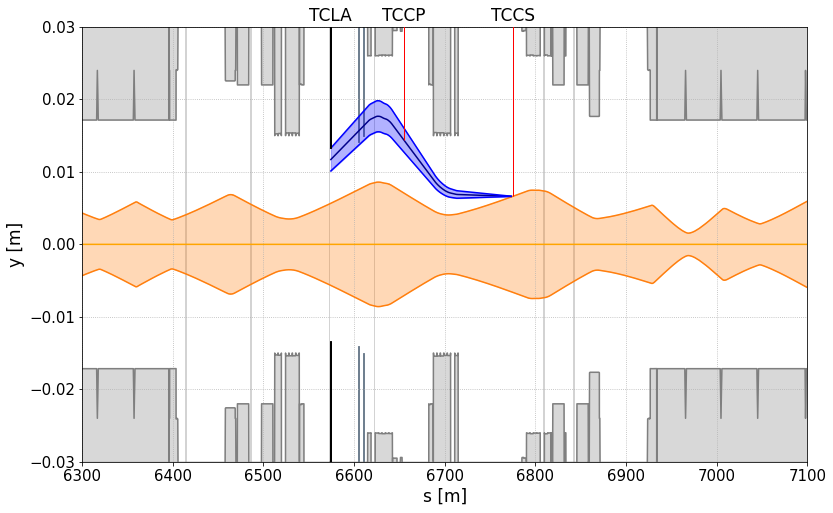

In [21]:
fig, ir3_plot = plt.subplots(figsize=(13,8))
plot_IR3(ir3_plot, df_cry_opt, df_cry_part_chann, df_cry_part_chann_upper,df_cry_part_chann_lower,df_apertures, df_coll_450)

In [22]:
"""df_apertures.to_csv("./input_files/kay_line/csv_pandas_dataframes/apertures.csv")"""

'df_apertures.to_csv("./input_files/kay_line/csv_pandas_dataframes/apertures.csv")'

In [23]:
"""df_cry_opt.to_csv("./input_files/kay_line/csv_pandas_dataframes/450_twiss.csv")
df_cry_part_chann.to_csv("./input_files/kay_line/csv_pandas_dataframes/450_chann.csv")
df_cry_part_chann_upper.to_csv("./input_files/kay_line/csv_pandas_dataframes/450_chann_upper.csv")
df_cry_part_chann_lower.to_csv("./input_files/kay_line/csv_pandas_dataframes/450_chann_lower.csv")
df_coll_450.to_csv("./input_files/kay_line/csv_pandas_dataframes/450_collimators.csv")"""

'df_cry_opt.to_csv("./input_files/kay_line/csv_pandas_dataframes/450_twiss.csv")\ndf_cry_part_chann.to_csv("./input_files/kay_line/csv_pandas_dataframes/450_chann.csv")\ndf_cry_part_chann_upper.to_csv("./input_files/kay_line/csv_pandas_dataframes/450_chann_upper.csv")\ndf_cry_part_chann_lower.to_csv("./input_files/kay_line/csv_pandas_dataframes/450_chann_lower.csv")\ndf_coll_450.to_csv("./input_files/kay_line/csv_pandas_dataframes/450_collimators.csv")'

## 1 TeV

In [24]:
energy=1000e9
#energy_inj=6800e9

line_cry_b4.discard_tracker() 


line_cry_b4.particle_ref = xp.Particles(p0c=energy, #eV
                                 q0=1, mass0=xp.PROTON_MASS_EV)
line_cry_b4.build_tracker(_context=context)

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [25]:
beta_rel=line_cry_b4.particle_ref._xobject.beta0[0]
emittance_phy = normalized_emittance/(line_cry_b4.particle_ref._xobject.beta0[0]*line_cry_b4.particle_ref._xobject.gamma0[0])
critical_angle=np.sqrt(2*16/(energy*beta_rel))

In [26]:
tw_opt_cry=line_cry_b4.twiss(method="4d")
#tw_opt_cry=line_cry_b4.twiss()

beta_y_cry1  = tw_opt_cry['bety', 'mt_cry1']
alpha_y_cry1 = tw_opt_cry['alfy', 'mt_cry1']

#tw_opt_cry[['s', 'alfx', 'alfy', 'betx', 'bety', 'y'], ["mt_cry1","mt_cry2","mt_det1"]].to_pandas()

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [27]:
df_coll_1000 = load_coll_yaml(coll_file_1000, tw_opt_cry.to_pandas(), xp.PROTON_MASS_EV, line_cry_b4.particle_ref.energy0)

In [28]:
cry_part_opt = xp.Particles(p0c=energy, #eV
                        q0=1, mass0=xp.PROTON_MASS_EV,
                        x=0,
                        px=0,
                        y=5*np.sqrt(emittance_phy*beta_y_cry1),
                        py=-5*alpha_y_cry1*np.sqrt(emittance_phy/beta_y_cry1),
                        _context=context)

cry_part_chann = xp.Particles(p0c=energy, #eV
                        q0=1, mass0=xp.PROTON_MASS_EV,
                        x=0,
                        px=0,
                        y=5*np.sqrt(emittance_phy*beta_y_cry1),
                        py=-5*alpha_y_cry1*np.sqrt(emittance_phy/beta_y_cry1)+50e-6,
                        _context=context)


cry_part_chann_upper = xp.Particles(p0c=energy, #eV
                        q0=1, mass0=xp.PROTON_MASS_EV,
                        x=0,
                        px=0,
                        y=5*np.sqrt(emittance_phy*beta_y_cry1),
                        py=-5*alpha_y_cry1*np.sqrt(emittance_phy/beta_y_cry1)+50e-6+critical_angle,
                        _context=context)


cry_part_chann_lower = xp.Particles(p0c=energy, #eV
                        q0=1, mass0=xp.PROTON_MASS_EV,
                        x=0,
                        px=0,
                        y=5*np.sqrt(emittance_phy*beta_y_cry1),
                        py=-5*alpha_y_cry1*np.sqrt(emittance_phy/beta_y_cry1)+50e-6-critical_angle,
                        _context=context)

In [29]:
df_cry_opt_1TeV = change_coordinates_to_b1(tw_opt_cry.to_pandas())
df_cry_opt_1TeV['5_sigma_y'] = 5*np.sqrt(emittance_phy*df_cry_opt_1TeV['bety'])

line_cry_b4.track(cry_part_chann, turn_by_turn_monitor = 'ONE_TURN_EBE', ele_start='mt_cry1')
df_cry_part_chann_1TeV = change_coordinates_to_b1(pd.DataFrame(list(zip(line_cry_b4.record_last_track.s[0], -1*line_cry_b4.record_last_track.x[0], line_cry_b4.record_last_track.y[0])), columns =['s', 'x', 'y']))
df_cry_part_chann_1TeV = extract_channelled(df_cry_part_chann_1TeV)

line_cry_b4.track(cry_part_chann_upper, turn_by_turn_monitor = 'ONE_TURN_EBE', ele_start='mt_cry1')
df_cry_part_chann_upper_1TeV = change_coordinates_to_b1(pd.DataFrame(list(zip(line_cry_b4.record_last_track.s[0], -1*line_cry_b4.record_last_track.x[0], line_cry_b4.record_last_track.y[0])), columns =['s', 'x', 'y']))
df_cry_part_chann_upper_1TeV = extract_channelled(df_cry_part_chann_upper_1TeV)

line_cry_b4.track(cry_part_chann_lower, turn_by_turn_monitor = 'ONE_TURN_EBE', ele_start='mt_cry1')
df_cry_part_chann_lower_1TeV = change_coordinates_to_b1(pd.DataFrame(list(zip(line_cry_b4.record_last_track.s[0], -1*line_cry_b4.record_last_track.x[0], line_cry_b4.record_last_track.y[0])), columns =['s', 'x', 'y']))
df_cry_part_chann_lower_1TeV = extract_channelled(df_cry_part_chann_lower_1TeV)

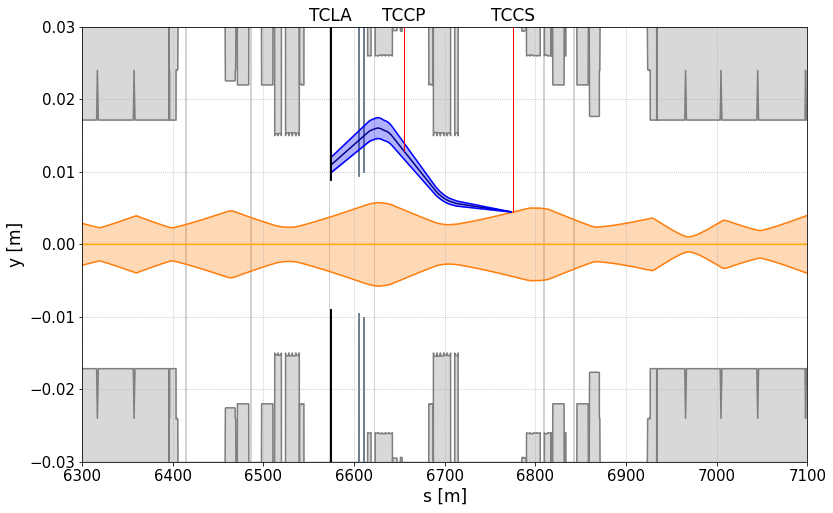

In [30]:
fig, ir3_plot_1TeV = plt.subplots(figsize=(13,8))

plot_IR3(ir3_plot_1TeV, df_cry_opt_1TeV, df_cry_part_chann_1TeV, df_cry_part_chann_upper_1TeV,df_cry_part_chann_lower_1TeV,df_apertures, df_coll_1000)

In [31]:
"""df_cry_opt_1TeV.to_csv("./input_files/kay_line/csv_pandas_dataframes/1000_twiss.csv")
df_cry_part_chann_1TeV.to_csv("./input_files/kay_line/csv_pandas_dataframes/1000_chann.csv")
df_cry_part_chann_upper_1TeV.to_csv("./input_files/kay_line/csv_pandas_dataframes/1000_chann_upper.csv")
df_cry_part_chann_lower_1TeV.to_csv("./input_files/kay_line/csv_pandas_dataframes/1000_chann_lower.csv")
df_coll_1000.to_csv("./input_files/kay_line/csv_pandas_dataframes/1000_collimators.csv")"""

'df_cry_opt_1TeV.to_csv("./input_files/kay_line/csv_pandas_dataframes/1000_twiss.csv")\ndf_cry_part_chann_1TeV.to_csv("./input_files/kay_line/csv_pandas_dataframes/1000_chann.csv")\ndf_cry_part_chann_upper_1TeV.to_csv("./input_files/kay_line/csv_pandas_dataframes/1000_chann_upper.csv")\ndf_cry_part_chann_lower_1TeV.to_csv("./input_files/kay_line/csv_pandas_dataframes/1000_chann_lower.csv")\ndf_coll_1000.to_csv("./input_files/kay_line/csv_pandas_dataframes/1000_collimators.csv")'

## 6.8 TeV

In [32]:
energy=6800e9

line_cry_b4_6800.particle_ref = xp.Particles(p0c=energy, #eV
                                 q0=1, mass0=xp.PROTON_MASS_EV)
line_cry_b4_6800.build_tracker(_context=context)

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [33]:
beta_rel = line_cry_b4_6800.particle_ref._xobject.beta0[0]
emittance_phy = normalized_emittance/(line_cry_b4_6800.particle_ref._xobject.beta0[0]*line_cry_b4_6800.particle_ref._xobject.gamma0[0])
critical_angle=np.sqrt(2*16/(energy*beta_rel))

In [34]:
tw_opt_cry=line_cry_b4_6800.twiss(method="4d")
#tw_opt_cry=line_cry_b4_6800.twiss()

beta_y_cry1  = tw_opt_cry['bety', 'mt_cry1']
alpha_y_cry1 = tw_opt_cry['alfy', 'mt_cry1']

#tw_opt_cry[['s', 'alfx', 'alfy', 'betx', 'bety', 'y'], ["mt_cry1","mt_cry2","mt_det1"]].to_pandas()

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [35]:
df_coll_6800 = load_coll_yaml(coll_file_6800, tw_opt_cry.to_pandas(), xp.PROTON_MASS_EV, line_cry_b4_6800.particle_ref.energy0)

In [36]:
cry_part_opt = xp.Particles(p0c=energy, #eV
                        q0=1, mass0=xp.PROTON_MASS_EV,
                        x=0,
                        px=0,
                        y=5*np.sqrt(emittance_phy*beta_y_cry1),
                        py=-5*alpha_y_cry1*np.sqrt(emittance_phy/beta_y_cry1),
                        _context=context)

cry_part_chann = xp.Particles(p0c=energy, #eV
                        q0=1, mass0=xp.PROTON_MASS_EV,
                        x=0,
                        px=0,
                        y=5*np.sqrt(emittance_phy*beta_y_cry1),
                        py=-5*alpha_y_cry1*np.sqrt(emittance_phy/beta_y_cry1)+50e-6,
                        _context=context)


cry_part_chann_upper = xp.Particles(p0c=energy, #eV
                        q0=1, mass0=xp.PROTON_MASS_EV,
                        x=0,
                        px=0,
                        y=5*np.sqrt(emittance_phy*beta_y_cry1),
                        py=-5*alpha_y_cry1*np.sqrt(emittance_phy/beta_y_cry1)+50e-6+critical_angle,
                        _context=context)


cry_part_chann_lower = xp.Particles(p0c=energy, #eV
                        q0=1, mass0=xp.PROTON_MASS_EV,
                        x=0,
                        px=0,
                        y=5*np.sqrt(emittance_phy*beta_y_cry1),
                        py=-5*alpha_y_cry1*np.sqrt(emittance_phy/beta_y_cry1)+50e-6-critical_angle,
                        _context=context)

In [37]:
df_cry_opt_6800GeV = change_coordinates_to_b1(tw_opt_cry.to_pandas())
df_cry_opt_6800GeV['5_sigma_y'] = 5*np.sqrt(emittance_phy*df_cry_opt_6800GeV['bety'])

line_cry_b4.track(cry_part_chann, turn_by_turn_monitor = 'ONE_TURN_EBE', ele_start='mt_cry1')
df_cry_part_chann_6800GeV = change_coordinates_to_b1(pd.DataFrame(list(zip(line_cry_b4.record_last_track.s[0], -1*line_cry_b4.record_last_track.x[0], line_cry_b4.record_last_track.y[0])), columns =['s', 'x', 'y']))
df_cry_part_chann_6800GeV = extract_channelled(df_cry_part_chann_6800GeV)

line_cry_b4.track(cry_part_chann_upper, turn_by_turn_monitor = 'ONE_TURN_EBE', ele_start='mt_cry1')
df_cry_part_chann_upper_6800GeV = change_coordinates_to_b1(pd.DataFrame(list(zip(line_cry_b4.record_last_track.s[0], -1*line_cry_b4.record_last_track.x[0], line_cry_b4.record_last_track.y[0])), columns =['s', 'x', 'y']))
df_cry_part_chann_upper_6800GeV = extract_channelled(df_cry_part_chann_upper_6800GeV)

line_cry_b4.track(cry_part_chann_lower, turn_by_turn_monitor = 'ONE_TURN_EBE', ele_start='mt_cry1')
df_cry_part_chann_lower_6800GeV = change_coordinates_to_b1(pd.DataFrame(list(zip(line_cry_b4.record_last_track.s[0], -1*line_cry_b4.record_last_track.x[0], line_cry_b4.record_last_track.y[0])), columns =['s', 'x', 'y']))
df_cry_part_chann_lower_6800GeV = extract_channelled(df_cry_part_chann_lower_6800GeV)

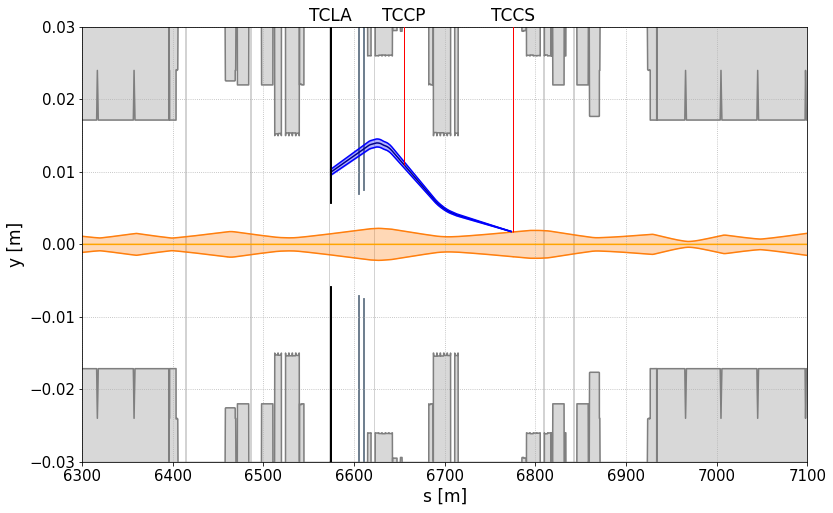

In [38]:
fig, ir3_plot_6800GeV = plt.subplots(figsize=(13,8))

plot_IR3(ir3_plot_6800GeV, df_cry_opt_6800GeV, df_cry_part_chann_6800GeV, df_cry_part_chann_upper_6800GeV,df_cry_part_chann_lower_6800GeV,df_apertures, df_coll_6800)

In [39]:
"""df_cry_opt_6800GeV.to_csv("./input_files/kay_line/csv_pandas_dataframes/6800_twiss.csv")
df_cry_part_chann_6800GeV.to_csv("./input_files/kay_line/csv_pandas_dataframes/6800_chann.csv")
df_cry_part_chann_upper_6800GeV.to_csv("./input_files/kay_line/csv_pandas_dataframes/6800_chann_upper.csv")
df_cry_part_chann_lower_6800GeV.to_csv("./input_files/kay_line/csv_pandas_dataframes/6800_chann_lower.csv")
df_coll_6800.to_csv("./input_files/kay_line/csv_pandas_dataframes/6800_collimators.csv")"""

'df_cry_opt_6800GeV.to_csv("./input_files/kay_line/csv_pandas_dataframes/6800_twiss.csv")\ndf_cry_part_chann_6800GeV.to_csv("./input_files/kay_line/csv_pandas_dataframes/6800_chann.csv")\ndf_cry_part_chann_upper_6800GeV.to_csv("./input_files/kay_line/csv_pandas_dataframes/6800_chann_upper.csv")\ndf_cry_part_chann_lower_6800GeV.to_csv("./input_files/kay_line/csv_pandas_dataframes/6800_chann_lower.csv")\ndf_coll_6800.to_csv("./input_files/kay_line/csv_pandas_dataframes/6800_collimators.csv")'

# Plots

In [40]:
df_apertures = load_apertures(line_cry_b4_aperture)

In [41]:
#df_apertures = pd.read_csv("./csv_pandas_dataframes/apertures.csv")
"""
df_cry_opt = pd.read_csv("./input_files/kay_line/csv_pandas_dataframes/450_twiss.csv")
df_cry_part_chann = pd.read_csv("./input_files/kay_line/csv_pandas_dataframes/450_chann.csv")
df_cry_part_chann_upper = pd.read_csv("./input_files/kay_line/csv_pandas_dataframes/450_chann_upper.csv")
df_cry_part_chann_lower = pd.read_csv("./input_files/kay_line/csv_pandas_dataframes/450_chann_lower.csv")
df_coll_450 =  pd.read_csv("./input_files/kay_line/csv_pandas_dataframes/450_collimators.csv")

df_cry_opt_1TeV = pd.read_csv("./input_files/kay_line/csv_pandas_dataframes/1000_twiss.csv")
df_cry_part_chann_1TeV = pd.read_csv("./input_files/kay_line/csv_pandas_dataframes/1000_chann.csv")
df_cry_part_chann_upper_1TeV = pd.read_csv("./input_files/kay_line/csv_pandas_dataframes/1000_chann_upper.csv")
df_cry_part_chann_lower_1TeV = pd.read_csv("./input_files/kay_line/csv_pandas_dataframes/1000_chann_lower.csv")
df_coll_1000 = pd.read_csv("./input_files/kay_line/csv_pandas_dataframes/1000_collimators.csv")

df_cry_opt_6800GeV = pd.read_csv("./input_files/kay_line/csv_pandas_dataframes/6800_twiss.csv")
df_cry_part_chann_6800GeV = pd.read_csv("./input_files/kay_line/csv_pandas_dataframes/6800_chann.csv")
df_cry_part_chann_upper_6800GeV = pd.read_csv("./input_files/kay_line/csv_pandas_dataframes/6800_chann_upper.csv")
df_cry_part_chann_lower_6800GeV= pd.read_csv("./input_files/kay_line/csv_pandas_dataframes/6800_chann_lower.csv")
df_coll_6800 =  pd.read_csv("./input_files/kay_line/csv_pandas_dataframes/6800_collimators.csv")"""

'\ndf_cry_opt = pd.read_csv("./input_files/kay_line/csv_pandas_dataframes/450_twiss.csv")\ndf_cry_part_chann = pd.read_csv("./input_files/kay_line/csv_pandas_dataframes/450_chann.csv")\ndf_cry_part_chann_upper = pd.read_csv("./input_files/kay_line/csv_pandas_dataframes/450_chann_upper.csv")\ndf_cry_part_chann_lower = pd.read_csv("./input_files/kay_line/csv_pandas_dataframes/450_chann_lower.csv")\ndf_coll_450 =  pd.read_csv("./input_files/kay_line/csv_pandas_dataframes/450_collimators.csv")\n\ndf_cry_opt_1TeV = pd.read_csv("./input_files/kay_line/csv_pandas_dataframes/1000_twiss.csv")\ndf_cry_part_chann_1TeV = pd.read_csv("./input_files/kay_line/csv_pandas_dataframes/1000_chann.csv")\ndf_cry_part_chann_upper_1TeV = pd.read_csv("./input_files/kay_line/csv_pandas_dataframes/1000_chann_upper.csv")\ndf_cry_part_chann_lower_1TeV = pd.read_csv("./input_files/kay_line/csv_pandas_dataframes/1000_chann_lower.csv")\ndf_coll_1000 = pd.read_csv("./input_files/kay_line/csv_pandas_dataframes/1000_col

In [42]:
# fig = plt.figure(figsize=(30,16))

# inj_plot = plt.subplot(2,2,1)
# OneTev_plot = plt.subplot(2,2,2)
# SixEightTev_plot = plt.subplot(2,2,3)

# plot_IR3(inj_plot, df_cry_opt, df_cry_part_chann, df_cry_part_chann_upper,df_cry_part_chann_lower,df_apertures)
# inj_plot.set_title(label='Energy = 450 GeV', y=1.05, fontsize=18)
# plot_IR3(OneTev_plot, df_cry_opt_1TeV, df_cry_part_chann_1TeV, df_cry_part_chann_upper_1TeV,df_cry_part_chann_lower_1TeV,df_apertures)
# OneTev_plot.set_title(label='Energy = 1 TeV', y=1.05, fontsize=18)
# plot_IR3(SixEightTev_plot, df_cry_opt_6800GeV, df_cry_part_chann_6800GeV, df_cry_part_chann_upper_6800GeV,df_cry_part_chann_lower_6800GeV,df_apertures)
# SixEightTev_plot.set_title(label='Energy = 6.8 TeV', y=1.05, fontsize=18)

# #text_b2 = r'$x$ = ' f'{x_b2:.3f} m' r'        $y$ = ' f'{y_b2:.3f} m' '\n' r"$p_x$ = " f'{px_b2:.3f} rad' r"    $p_y$ = " f'{py_b2:.5f} rad'

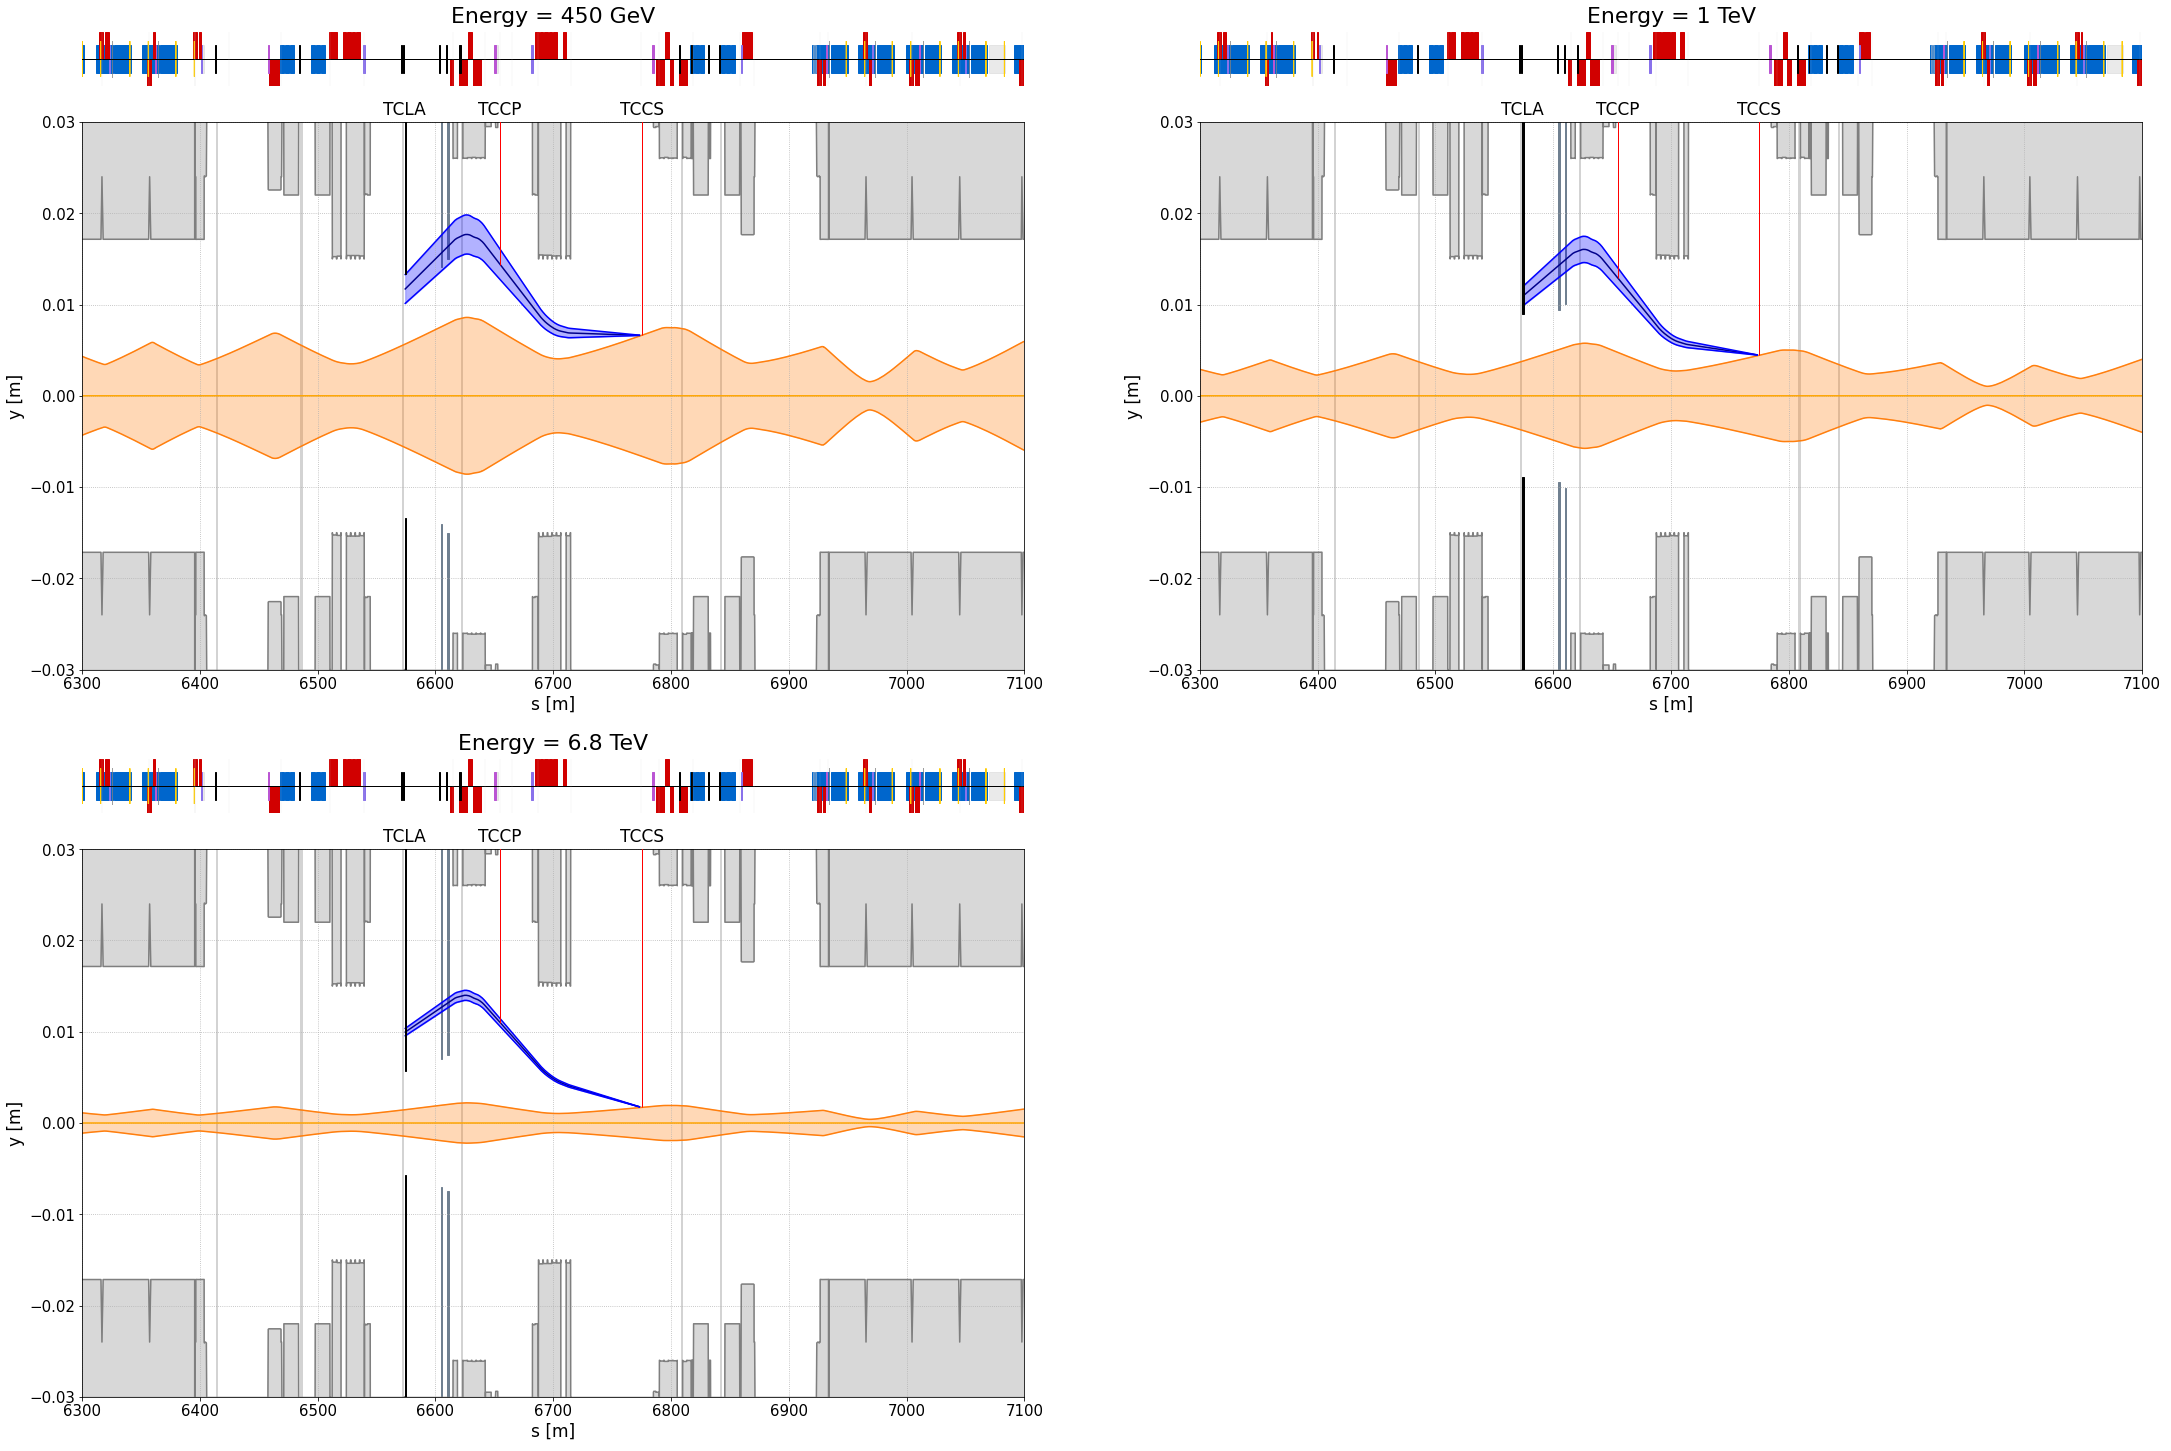

In [43]:
fig = plt.figure(layout='constrained', figsize=(30,20))
subfigs = fig.subfigures(2, 2, wspace=0.07)

inj_plot = subfigs[0][0].subplots(2, 1, gridspec_kw={'height_ratios': [0.1, 1]}, sharex=True)
plot_IR3(inj_plot[1], df_cry_opt, df_cry_part_chann, df_cry_part_chann_upper,df_cry_part_chann_lower, df_apertures, df_coll_450)
pymadx.Plot._SetMachineAxesStyle(inj_plot[0])
DrawMachineLattice(inj_plot[0], layout_data_object)
inj_plot[0].set_xlim(6300,7100)
inj_plot[0].set_title(label='Energy = 450 GeV', y=1.05, fontsize=22)
#plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.1)

OneTev_plot = subfigs[0][1].subplots(2, 1, gridspec_kw={'height_ratios': [0.1, 1]}, sharex=True)
plot_IR3(OneTev_plot[1], df_cry_opt_1TeV, df_cry_part_chann_1TeV, df_cry_part_chann_upper_1TeV,df_cry_part_chann_lower_1TeV, df_apertures, df_coll_1000)
pymadx.Plot._SetMachineAxesStyle(OneTev_plot[0])
DrawMachineLattice(OneTev_plot[0], layout_data_object)
OneTev_plot[0].set_xlim(6300,7100)
OneTev_plot[0].set_title(label='Energy = 1 TeV', y=1.05, fontsize=22)
#plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.1)


SixEightTev_plot = subfigs[1][0].subplots(2, 1, gridspec_kw={'height_ratios': [0.1, 1]}, sharex=True)
plot_IR3(SixEightTev_plot[1], df_cry_opt_6800GeV, df_cry_part_chann_6800GeV, df_cry_part_chann_upper_6800GeV,df_cry_part_chann_lower_6800GeV, df_apertures, df_coll_6800)
pymadx.Plot._SetMachineAxesStyle(SixEightTev_plot[0])
DrawMachineLattice(SixEightTev_plot[0], layout_data_object)
SixEightTev_plot[0].set_xlim(6300,7100)
SixEightTev_plot[0].set_title(label='Energy = 6.8 TeV', y=1.05, fontsize=22)
#plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.1)

plt.savefig("./Outputdata/IR3_channeling.pdf")
plt.savefig("./Outputdata/IR3_channeling.jpg")

In [47]:
def calc_nsigma_cry2(df_twiss, df_chann, energy):

    emittance_phy = _norm_to_geom_emittance(normalized_emittance,xp.PROTON_MASS_EV, energy)
    s_centre = float(df_twiss[df_twiss["name"] == 'mt_cry2']['s'])
    hgap =  df_chann[df_chann['s'] == s_centre]['y'].iloc[0]  - df_twiss[df_twiss['s'] == s_centre]['y'].iloc[0]
    beta_y = float(df_twiss[df_twiss["name"] == 'mt_cry2']['bety'])
    sigma =  np.sqrt(emittance_phy*beta_y)

    #five_sig_gap  = df_twiss[df_twiss['s'] == s_centre]['5_sigma_y'].iloc[0] - df_twiss[df_twiss['s'] == s_centre]['y'].iloc[0]
    #print('check: ', five_sig_gap/sigma)
    
    return hgap/sigma

In [48]:
print('Sigma CRY2 at 450 GeV = ', calc_nsigma_cry2(df_cry_opt, df_cry_part_chann, 450e9))
print('Sigma CRY2 at 1000 GeV = ', calc_nsigma_cry2(df_cry_opt_1TeV, df_cry_part_chann_1TeV, 1000e9))
print('Sigma CRY2 at 6800 GeV = ', calc_nsigma_cry2(df_cry_opt_6800GeV, df_cry_part_chann_6800GeV, 6800e9))

Sigma CRY2 at 450 GeV =  10.162382374858547
Sigma CRY2 at 1000 GeV =  13.570781589140799
Sigma CRY2 at 6800 GeV =  30.221524832897853
